In [1]:
#This script if for investigating how deep of a circuit you can run with an IBM device using the corresponding backend noise model
#Designed to be run locally, but there is a HPC version called 'mainMaxDepth.py'
#remaining use is for testing small numbers of repitions or noiseless simulations, as well as the plotting of results
import sys
import json
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import (
    FakeBrisbane,
    FakeSherbrooke,
    FakeTorino,
)  # For simulation with realistic noise

In [2]:
# //////////    Variables    //////////
desiredProblemType = 'Knapsack' #options: 'Knapsack', 'TSP' if using TSP remember to check the bit about targetQubitRange
minScale = 2#minimum number of qubits to test
maxScale = 12 #maximum number of qubits to test
reps_p = 1

repsPerProblemScale = 100
# This is the number of times that the optimsation of parameters is repeated for each qubit number.
# This avoids issues with parameter initalisation. Should be 100 for final test

chosenBackend = 'noiseless' #options: 'FakeBrisbane', 'FakeSherbrooke', 'FakeTorino', 'noiseless'

In [4]:
# //////////    Functions    //////////
def load_qubo_and_build_hamiltonian(file_path):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        all_qubo_data = json.load(f)

    if isinstance(all_qubo_data, list):
        # If it's a list, take the first element
        qubo_data = all_qubo_data[0]
    else:
        # If it's already a dictionary, just use it directly
        qubo_data = all_qubo_data


    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset, backend_total_qubits=127): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    
    return cost_float

def save_results_to_json(results_dict, problem_type, minQubits, maxQubits, layers, backend_name):
    filename = f"maxDepthExperimentResults/{problem_type}_{minQubits}-{maxQubits}q_p{layers}_{backend_name}.json"
    
    with open(filename, 'w') as f:
        json.dump(results_dict, f, indent=4)

def plot_distribution_grid(results_by_qubit):
    """
    Plots a grid of result distributions with a fixed y-axis (0-1),
    and a legend-style box identifying the top 3 results.
    """
    qubit_keys = sorted(results_by_qubit.keys())
    num_plots = len(qubit_keys)
    
    cols = int(np.ceil(np.sqrt(num_plots)))
    rows = int(np.ceil(num_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = np.array(axes).flatten()

    for i, qubit_num in enumerate(qubit_keys):
        ax = axes[i]
        distribution = results_by_qubit[qubit_num]
        
        # Sort by ascending binary order
        sorted_results = sorted(distribution.items(), key=lambda item: int(item[0], 2))
        
        if sorted_results:
            # Calculate probabilities
            total_shots = sum(count for bitstring, count in sorted_results)
            labels, values = zip(*sorted_results)
            probabilities = [v / total_shots for v in values]

            # --- CHANGE 2: Create bar chart with solid blue bars ---
            x_positions = np.arange(len(labels))
            ax.bar(x_positions, probabilities, color='blue')
            
            # --- CHANGE 3: Create a legend-style text box ---
            # Find the top 3 results by sorting by probability
            top_3_by_prob = sorted(distribution.items(), key=lambda item: item[1], reverse=True)[:3]
            
            # Build the text for the legend box
            legend_lines = []
            placements = ["1st", "2nd", "3rd"]
            for j, (bitstring, count) in enumerate(top_3_by_prob):
                legend_lines.append(f"{placements[j]}: {bitstring}")
            legend_text = "\n".join(legend_lines)
            
            # Add the text box to the top-right corner of the plot
            ax.text(0.97, 0.97, legend_text,
                    transform=ax.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

        # --- CHANGE 1: Set fixed y-axis range ---
        ax.set_ylim(0, 1)

        # Configure axis labels and ticks
        ax.set_title(f"Distribution for {qubit_num} Qubits")
        ax.set_ylabel("Probability")
        ax.set_xlabel("")
        ax.set_xticks([])

    # Clean up the figure
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
        
    fig.suptitle("Result Probabilities vs. Problem Scale", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_comparison_grid(filenames, plot_labels, qubits_to_plot):
    all_results_data = {}
    for i, filename in enumerate(filenames):
        try:
            with open(filename, 'r') as f:
                data = {int(k): v for k, v in json.load(f).items()}
                all_results_data[plot_labels[i]] = data
        except FileNotFoundError:
            print(f"Warning: File '{filename}' not found. Skipping.")
            continue

    if not all_results_data:
        print("Error: No valid data was loaded. Aborting plot.")
        return

    # Set up the subplot grid
    num_plots = len(qubits_to_plot)
    cols = int(np.ceil(np.sqrt(num_plots)))
    rows = int(np.ceil(num_plots / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).flatten()

    # Create a subplot for each specified qubit number
    for i, qubit_num in enumerate(qubits_to_plot):
        ax = axes[i]
       
        # Gather all distributions for this qubit number
        distributions_for_qubit = []
        labels_for_qubit = []
        for label, results_dict in all_results_data.items():
            if qubit_num in results_dict:
                distributions_for_qubit.append(results_dict[qubit_num])
                labels_for_qubit.append(label)

        # Create a master list of all unique bitstrings, sorted numerically
        all_keys = set()
        for dist in distributions_for_qubit:
            all_keys.update(dist.keys())
        master_labels = sorted(list(all_keys), key=lambda k: int(k, 2))

        # Plot each distribution against the common master x-axis
        for j, distribution in enumerate(distributions_for_qubit):
            label = labels_for_qubit[j]
            total_shots = sum(distribution.values())
            
            if total_shots > 0:
                # Create a probability map for quick lookups
                prob_map = {key: val / total_shots for key, val in distribution.items()}
                # Build the probability vector aligned with the master_labels
                # If a bitstring is not in this distribution, its probability is 0
                probabilities = [prob_map.get(key, 0) for key in master_labels]
                
                ax.plot(probabilities, linestyle='-', label=label)

        # Configure the subplot
        ax.set_title(f"Outcome Probabilities for {qubit_num} Qubits")
        ax.set_xlabel("Outcome (Sorted by Binary Value)")
        ax.set_ylabel("Probability")
        ax.set_ylim(0, 0.3)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xticks([])

    # Clean up and show the final figure
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
    fig.suptitle("Comparison of Result Distributions Across Backends", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
if chosenBackend == 'FakeBrisbane':
    backend_simulator = AerSimulator.from_backend(FakeBrisbane())
elif chosenBackend == 'FakeSherbrooke':
    backend_simulator = AerSimulator.from_backend(FakeSherbrooke())
elif chosenBackend == 'FakeTorino':
    backend_simulator = AerSimulator.from_backend(FakeTorino())
elif chosenBackend == 'noiseless':
    backend_simulator = AerSimulator()

targetQubitRange = range(minScale, maxScale+1) #range of qubits to test
if desiredProblemType == 'TSP': #this bit is because i am lazy and TSP can only work for qubit numbers that are squares (4,9,16,25...)
    targetQubitRange = (minScale, maxScale)

: 

In [ ]:
# Training the QAOA for each problem scale and getting the best parameters for each scale achieved after 'repsPerProblemScale' runs
bestParameters = {}
for qubitNum in targetQubitRange:
    #file bizniz
    filename = f"QUBO_batches/batch_QUBO_data_{desiredProblemType}_{qubitNum}q_.json"
    print(f"Training QAOA for first QUBO in {filename}...")
    cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian(filename)
    #print(f"Number of qubits (inferred from terms): {num_qubits}")

    #circuit compilation bizniz
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps_p)
    circuit.measure_all() 
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)
    candidate_circuit = pm.run(circuit)
    estimator = Estimator(mode=backend_simulator)
    transpiledCircuitDepth = candidate_circuit.depth()
    print(f"Transpiled circuit depth: {transpiledCircuitDepth}")

    #keeping track of parameters and associated cost function values produced so far for this problem scale
    allResults = []

    for repitition in range(1, repsPerProblemScale+1):

        #creating random inital parameters
        initial_betas = (np.random.rand(reps_p) * np.pi).tolist()
        initial_gammas = (np.random.rand(reps_p) * np.pi).tolist()
        initial_params = initial_betas + initial_gammas

        #training QAOA parameters
        #numOptimisations = 0
        print(f"\rRunning repitition {repitition}/{repsPerProblemScale} for {qubitNum} qubit {desiredProblemType} problem...", end="")
        result = minimize(
            cost_func_estimator,
            initial_params,
            args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
            method="COBYLA",
            tol=1e-3,
            options={"maxiter": 1000}, # Adjust as needed
        )
        allResults.append([result.fun, result.x])
     
    qubitWiseBestResult = min(allResults, key=lambda item: item[0])
    qubitWiseBestParameters = qubitWiseBestResult[1]
    bestParameters[qubitNum] = {
    "transpiledDepth": transpiledCircuitDepth,
    "bestParamsForScale": qubitWiseBestParameters
}

print(f"\nBest betas and gammas for each problem scale: {bestParameters}")

Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_TSP_16q_.json...
Transpiled circuit depth: 24
Running repitition 100/100 for 16 qubit TSP problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_TSP_16q_.json...
Transpiled circuit depth: 24
Running repitition 3/100 for 16 qubit TSP problem...

Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  File "/Users/kv18799/Github/QAOAstudygit/IBMQpynbvenv/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = sf.fun(x)
  File "/Users/kv18799/Github/QAOAstudygit/IBMQpynbvenv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File "/Users/kv18799/Github/QAOAstudygit/IBMQpynbvenv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()
  File "/Users/kv18799/Github/QAOAstudygit/IBMQpynbvenv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 163, in update_fun
    self.f = fun_wrapped(self.x)
  File "/Users/kv18799/Github/QAOAstudygit/IBMQpynb

In [ ]:
finalSamplingResults = {}
for qubitNum in targetQubitRange:
    filename = f"QUBO_batches/batch_QUBO_data_{desiredProblemType}_{qubitNum}q_.json"
    cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian(filename)
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps_p)
    circuit.measure_all() 
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)
    candidate_circuit = pm.run(circuit)
    optimized_circuit = candidate_circuit.assign_parameters(bestParameters[qubitNum]["bestParamsForScale"])
    sampler = Sampler(mode=backend_simulator)
    sampler.options.default_shots = 1000

    print(f"Running final sampling for {qubitNum} qubit {desiredProblemType} problem...")
    result = sampler.run([optimized_circuit]).result()
    dist = result[0].data.meas.get_counts()
    finalSamplingResults[qubitNum] = dist


Running final sampling for 2 qubit Knapsack problem...
Running final sampling for 3 qubit Knapsack problem...
Running final sampling for 4 qubit Knapsack problem...
Running final sampling for 5 qubit Knapsack problem...
Running final sampling for 6 qubit Knapsack problem...
Running final sampling for 7 qubit Knapsack problem...
Running final sampling for 8 qubit Knapsack problem...
Running final sampling for 9 qubit Knapsack problem...
Running final sampling for 10 qubit Knapsack problem...
Running final sampling for 11 qubit Knapsack problem...
Running final sampling for 12 qubit Knapsack problem...


In [ ]:
save_results_to_json(finalSamplingResults, desiredProblemType, minScale, maxScale, reps_p, chosenBackend)

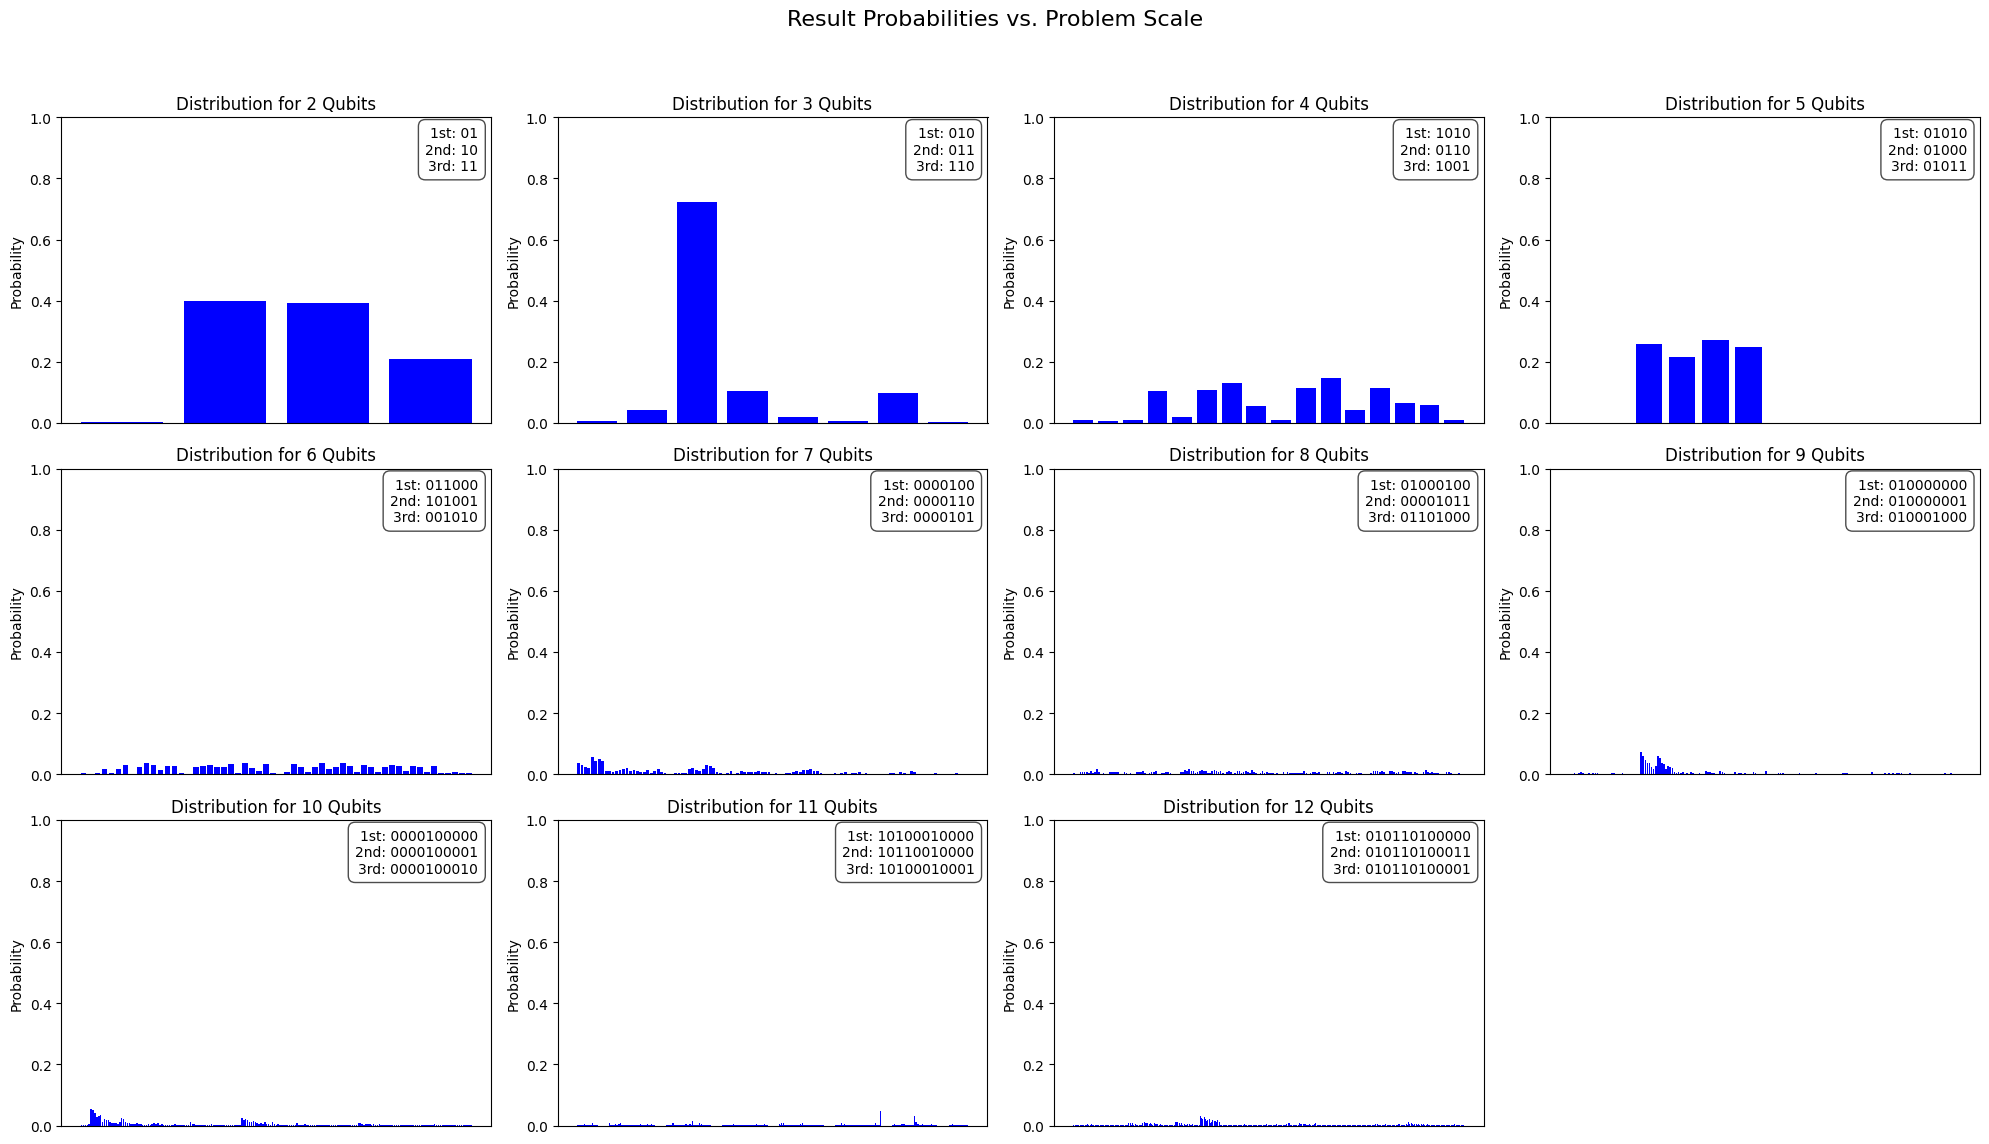

In [ ]:
dataFilename = "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_noiseless.json"  # Adjust this path as needed

with open(dataFilename, 'r') as f:
    data_from_json = json.load(f)

distributionsByProblemScale = {int(k): v for k, v in data_from_json.items()}

plot_distribution_grid(distributionsByProblemScale)

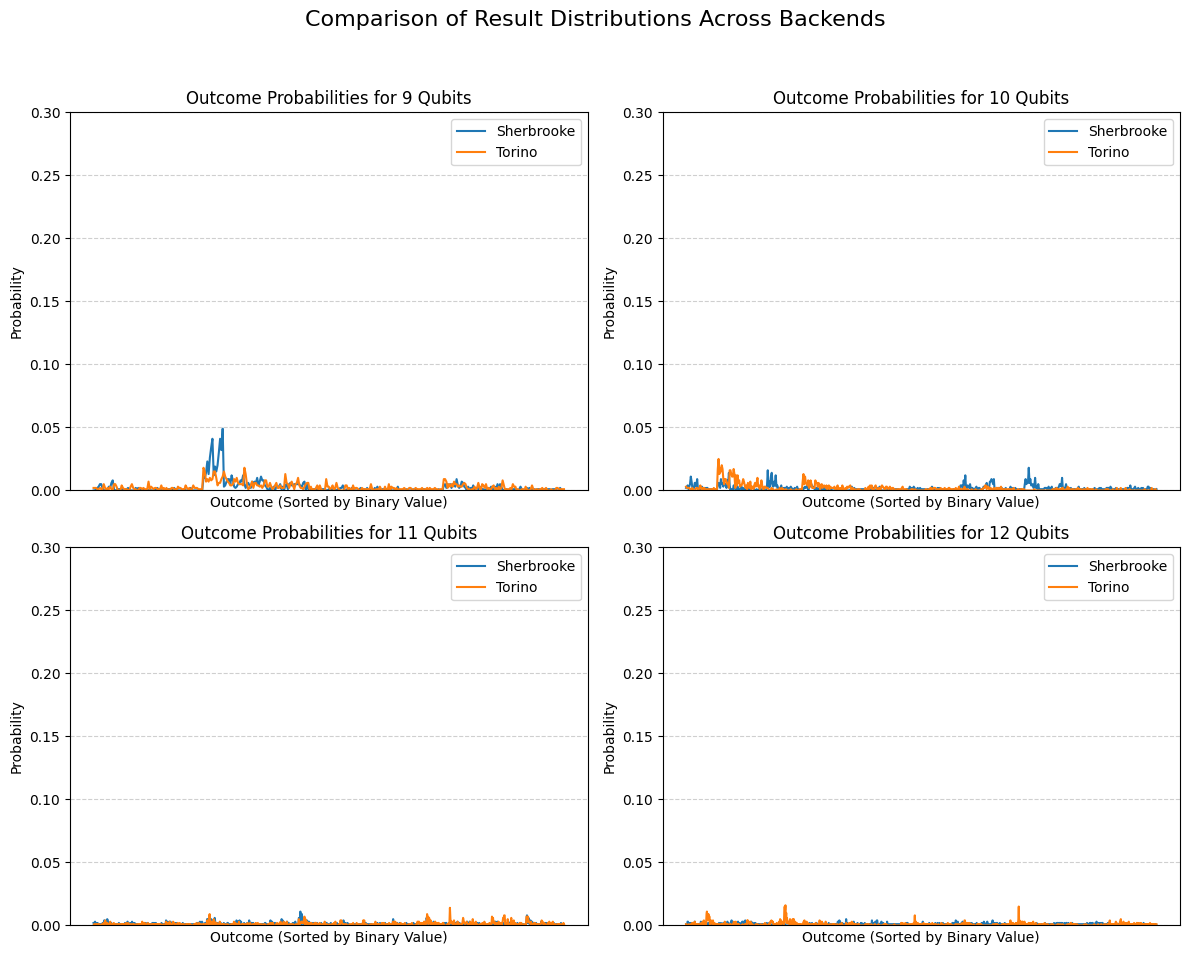

In [6]:
# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_FakeSherbrooke.json",
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_FakeBrisbane.json",
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_FakeTorino.json",
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_noiseless.json"
# ]
# labels_for_plot = [
#     "Sherbrooke",
#     "Brisbane",
#     "Torino",
#     "Noiseless"
# ]
# qubits_to_compare = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/TSP_4-9q_p1_FakeSherbrooke.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p1_FakeBrisbane.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p1_FakeTorino.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p1_noiseless.json"
# ]
# labels_for_plot = [
#     "Sherbrooke",
#     "Brisbane",
#     "Torino",
#     "Noiseless"
# ]
# qubits_to_compare = [4, 9]

# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_FakeSherbrooke.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_FakeBrisbane.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_FakeTorino.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_noiseless.json"
# ]
# labels_for_plot = [
#     "Sherbrooke",
#     "Brisbane",
#     "Torino",
#     "Noiseless"
# ]
# qubits_to_compare = [4, 9]

# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/TSP_4-9q_p1_noiseless.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_noiseless.json"
# ]
# labels_for_plot = [
#     "p=1",
#     "p=2"
# ]
# qubits_to_compare = [4, 9]

# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_noiseless.json",
#     "BPmaxDepthExperimentResults/Knapsack_2-12q_p2_noiseless.json"
# ]
# labels_for_plot = [
#     "p=1",
#     "p=2"
# ]
# qubits_to_compare = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# filenames_to_compare = [
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_FakeSherbrooke.json",
#     "BPmaxDepthExperimentResults/TSP_4-9q_p2_FakeTorino.json"
# ]
# labels_for_plot = [
#     "Sherbrooke",
#     "Torino"
# ]
# qubits_to_compare = [4, 9]

filenames_to_compare = [
    "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_FakeSherbrooke.json",
    "BPmaxDepthExperimentResults/Knapsack_2-12q_p1_FakeTorino.json"
]
labels_for_plot = [
    "Sherbrooke",
    "Torino"
]
qubits_to_compare = [9,10,11,12]

plot_comparison_grid(filenames_to_compare, labels_for_plot, qubits_to_compare)